# Лабораторная работа №3

Создадим бейзлайн с использованием стандартных классов DecisionTreeClassifier и DecisionTreeRegressor библиотеки sklearn. Для обеспечения сопоставимости с предыдущими лабораторными работами мы используем аналогичную стратегию минимальной предобработки: удаление пропусков и кодирование категориальных признаков методом Label Encoding. Важно отметить, что решающие деревья, в отличие от линейных моделей, способны работать с нелинейными зависимостями и не требуют масштабирования данных, однако склонны к переобучению при отсутствии ограничений на глубину. Мы обучим модели с гиперпараметрами по умолчанию, чтобы оценить их "чистую" производительность.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from collections import Counter
warnings.filterwarnings('ignore')


In [12]:
df_class = pd.read_csv('BankChurners.csv')
cols_to_drop = [c for c in df_class.columns if 'Naive_Bayes' in c] + ['CLIENTNUM']
df_class = df_class.drop(columns=cols_to_drop)

df_class_base = df_class.copy()
le = LabelEncoder()

for col in df_class_base.select_dtypes(include='object').columns:
    df_class_base[col] = le.fit_transform(df_class_base[col])

X_class = df_class_base.drop('Attrition_Flag', axis=1)
y_class = df_class_base['Attrition_Flag']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_c, y_train_c)

y_pred_c = dt_clf.predict(X_test_c)
y_prob_c = dt_clf.predict_proba(X_test_c)[:, 1]

df_reg = pd.read_excel('Data_Train.xlsx')
df_reg_base = df_reg.dropna().copy()

for col in df_reg_base.select_dtypes(include='object').columns:
    df_reg_base[col] = le.fit_transform(df_reg_base[col].astype(str))

X_reg = df_reg_base.drop('Price', axis=1)
y_reg = df_reg_base['Price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_r, y_train_r)

y_pred_r = dt_reg.predict(X_test_r)

print("Классификация")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_c, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c):.4f}")
print("\n")

print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_r, y_pred_r):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_r)):.2f}")
print(f"R2 Score: {r2_score(y_test_r, y_pred_r):.4f}")

Классификация
Accuracy: 0.9329
F1 Score: 0.8754
ROC AUC: 0.8735


Регрессия
MAE: 825.15
RMSE: 2015.39
R2 Score: 0.8116


Тестовый прогон показал печатляющие результаты, особенно в задаче регрессии. В классификации дерево продемонстрировало очень высокие Accuracy (0.93) и F1 (0.87), эффективно находя нелинейные паттерны, однако его ROC AUC (0.87) уступает логистической регрессии из-за дискретного характера предсказанных вероятностей. В задаче регрессии дерево установило абсолютный рекорд с R² 0.81, значительно превзойдя предыдущие модели, и снизило MAE до 825, что в два раза лучше результата линейной регрессии, что объясняется идеальной способностью деревьев моделировать "ступенчатые" структуры цен, характерные для тарифных сеток.

Деревья без ограничений (max_depth=None) склонны к переобучению. Они строят ветки до тех пор, пока в каждом листе не останется один уникальный пример. Это дает 100% точность на трейне, но на тесте модель может работать нестабильно.

## Улучшение бейзлайна

Для улучшения модели нам необходимо побороть переобучение. Основная гипотеза состоит в том, что ограничение глубины дерева и минимального количества объектов в листе  повысит обобщающую способность модели. Чтобы подтвердить это и выбрать диапазон гиперпараметров, мы построим кривые обучения, показывающие зависимость качества на обучающей и тестовой выборках от глубины дерева. Также мы визуализируем важность признаков, которую дерево рассчитывает автоматически, чтобы понять, какие факторы вносят основной вклад в принятие решений.

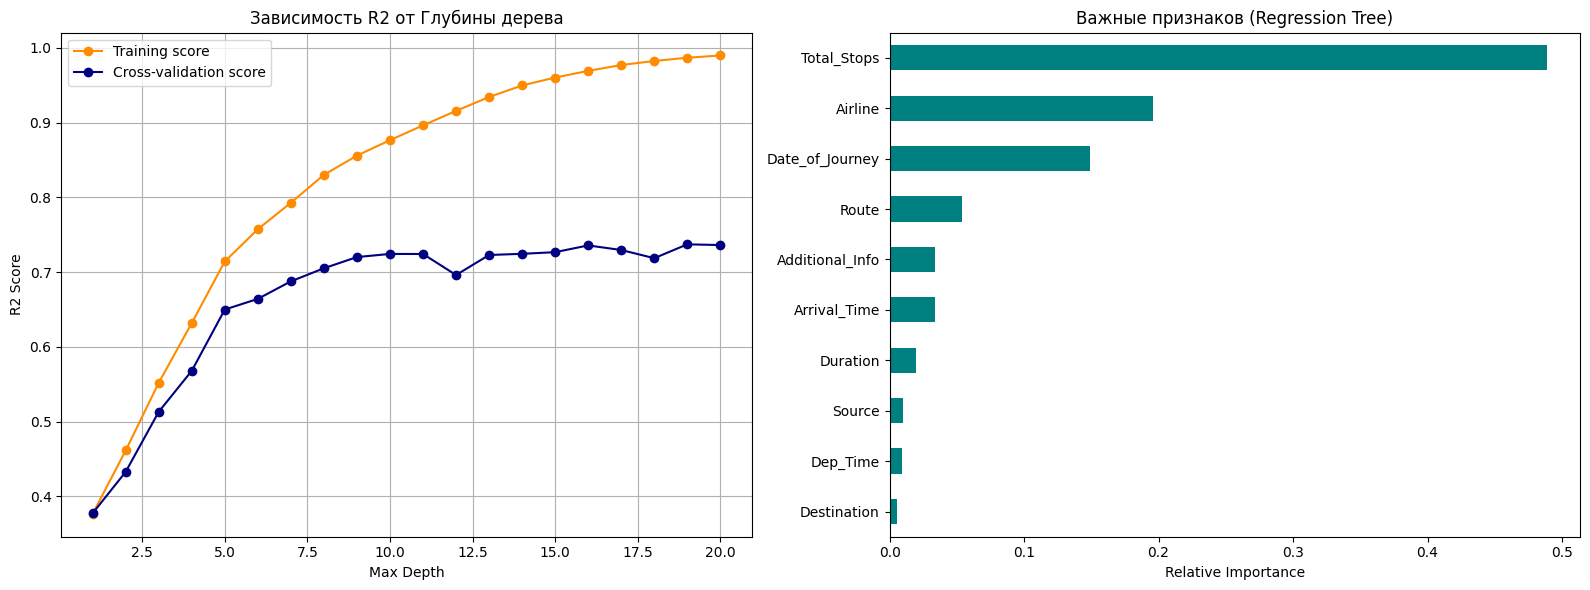

In [13]:

param_range = np.arange(1, 21)
train_scores, test_scores = validation_curve(
    DecisionTreeRegressor(random_state=42),
    X_train_r, y_train_r,
    param_name="max_depth",
    param_range=param_range,
    scoring="r2",
    cv=3,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

model_viz = DecisionTreeRegressor(max_depth=10, random_state=42)
model_viz.fit(X_train_r, y_train_r)

feat_importances = pd.Series(model_viz.feature_importances_, index=X_train_r.columns)


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.plot(param_range, test_mean, label="Cross-validation score", color="navy", marker='o')

plt.title("Зависимость R2 от Глубины дерева")
plt.xlabel("Max Depth")
plt.ylabel("R2 Score")
plt.legend(loc="best")
plt.grid(True)

plt.subplot(1, 2, 2)
feat_importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='teal')
plt.title("Важные признаков (Regression Tree)")
plt.xlabel("Relative Importance")

plt.tight_layout()
plt.show()

Анализ кривых валидации выявил классическое переобучение: с глубины 12-14 дерево начинает запоминать шум обучающей выборки, в то время как качество на валидации стагнирует, что указывает на оптимальный диапазон max_depth от 10 до 15. График важности признаков подтверждает доминирующую роль количества пересадок и авиакомпании, а также значимость даты, что подчеркивает потенциал для более эффективного выделения сезонных признаков (например, месяца и дня недели) вместо простой порядковой кодировки для построения более точных правил.

Для улучшения базовой модели будут реализованы две ключевые гипотезы. Во-первых, для ограничения сложности дерева и борьбы с переобучением в GridSearchCV будут добавлены гиперпараметры, контролирующие его глубину и минимальное количество образцов в листьях и для разделения (min_samples_leaf, min_samples_split). Во-вторых, будет проведен feature engineering, включающий явное выделение из даты и времени таких признаков, как месяц и день, а также преобразование длительности в минуты, что позволит дереву эффективнее захватывать сезонные закономерности и снизить избыточную глубину модели.

In [14]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

param_grid_dt_c = {
    'max_depth': [None, 8, 10, 12, 14, 16],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

grid_dt_c = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt_c,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1
)

grid_dt_c.fit(X_train_c, y_train_c)

best_tree_c = grid_dt_c.best_estimator_
y_pred_c_imp = best_tree_c.predict(X_test_c)
y_prob_c_imp = best_tree_c.predict_proba(X_test_c)[:, 1]

df_reg_imp = df_reg.dropna().copy()

df_reg_imp['Journey_Day'] = pd.to_datetime(df_reg_imp.Date_of_Journey, format="%d/%m/%Y").dt.day
df_reg_imp['Journey_Month'] = pd.to_datetime(df_reg_imp.Date_of_Journey, format="%d/%m/%Y").dt.month
df_reg_imp.drop('Date_of_Journey', axis=1, inplace=True)

df_reg_imp['Dep_Hour'] = pd.to_datetime(df_reg_imp['Dep_Time']).dt.hour
df_reg_imp['Dep_Min'] = pd.to_datetime(df_reg_imp['Dep_Time']).dt.minute
df_reg_imp.drop('Dep_Time', axis=1, inplace=True)

df_reg_imp['Arrival_Hour'] = pd.to_datetime(df_reg_imp['Arrival_Time']).dt.hour
df_reg_imp['Arrival_Min'] = pd.to_datetime(df_reg_imp['Arrival_Time']).dt.minute
df_reg_imp.drop('Arrival_Time', axis=1, inplace=True)

def convert_duration(duration):
    h, m = 0, 0
    parts = duration.split()
    for part in parts:
        if 'h' in part:
            h = int(part[:-1])
        if 'm' in part:
            m = int(part[:-1])
    return h * 60 + m

df_reg_imp['Duration_Mins'] = df_reg_imp['Duration'].apply(convert_duration)
df_reg_imp.drop('Duration', axis=1, inplace=True)

stops_map = {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}
df_reg_imp['Total_Stops'] = df_reg_imp['Total_Stops'].map(stops_map)
df_reg_imp.drop(['Route', 'Additional_Info'], axis=1, inplace=True)

le_reg = LabelEncoder()
for col in df_reg_imp.select_dtypes(include='object').columns:
    df_reg_imp[col] = le_reg.fit_transform(df_reg_imp[col])

X_reg_imp = df_reg_imp.drop('Price', axis=1)
y_reg_imp = df_reg_imp['Price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_imp, y_reg_imp, test_size=0.2, random_state=42)

param_grid_dt_r = {
    'max_depth': [8, 10, 12, 14, 16, 20],
    'min_samples_leaf': [2, 5, 10, 20],
    'min_samples_split': [2, 10, 20]
}

grid_dt_r = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dt_r,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid_dt_r.fit(X_train_r, y_train_r)

best_tree_r = grid_dt_r.best_estimator_
y_pred_r_imp = best_tree_r.predict(X_test_r)

print(f"Лучшие параметры классификации: {grid_dt_c.best_params_}")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_imp):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_c_imp, average='macro'):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_c, y_prob_c_imp):.4f}")

print("\n")
print(f"Лучшие параметры регрессии: {grid_dt_r.best_params_}")
print(f"MAE: {mean_absolute_error(y_test_r, y_pred_r_imp):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_r, y_pred_r_imp)):.2f}")
print(f"R2 Score: {r2_score(y_test_r, y_pred_r_imp):.4f}")

Лучшие параметры классификации: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10}
Accuracy: 0.9432
F1 Score: 0.8926
ROC AUC: 0.9504


Лучшие параметры регрессии: {'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 10}
MAE: 1219.16
RMSE: 2166.59
R2 Score: 0.7823


Метрики классификации выросли, но R2 заметно упала. Возможно дело в том, что модель была переобучена, а сейчас она работает лучше ценой мнимых пунктов в R2, но как мне кажется, нужно проанализировать столбцы, что я удалил.

Проанализируем Additional_Info и Route.

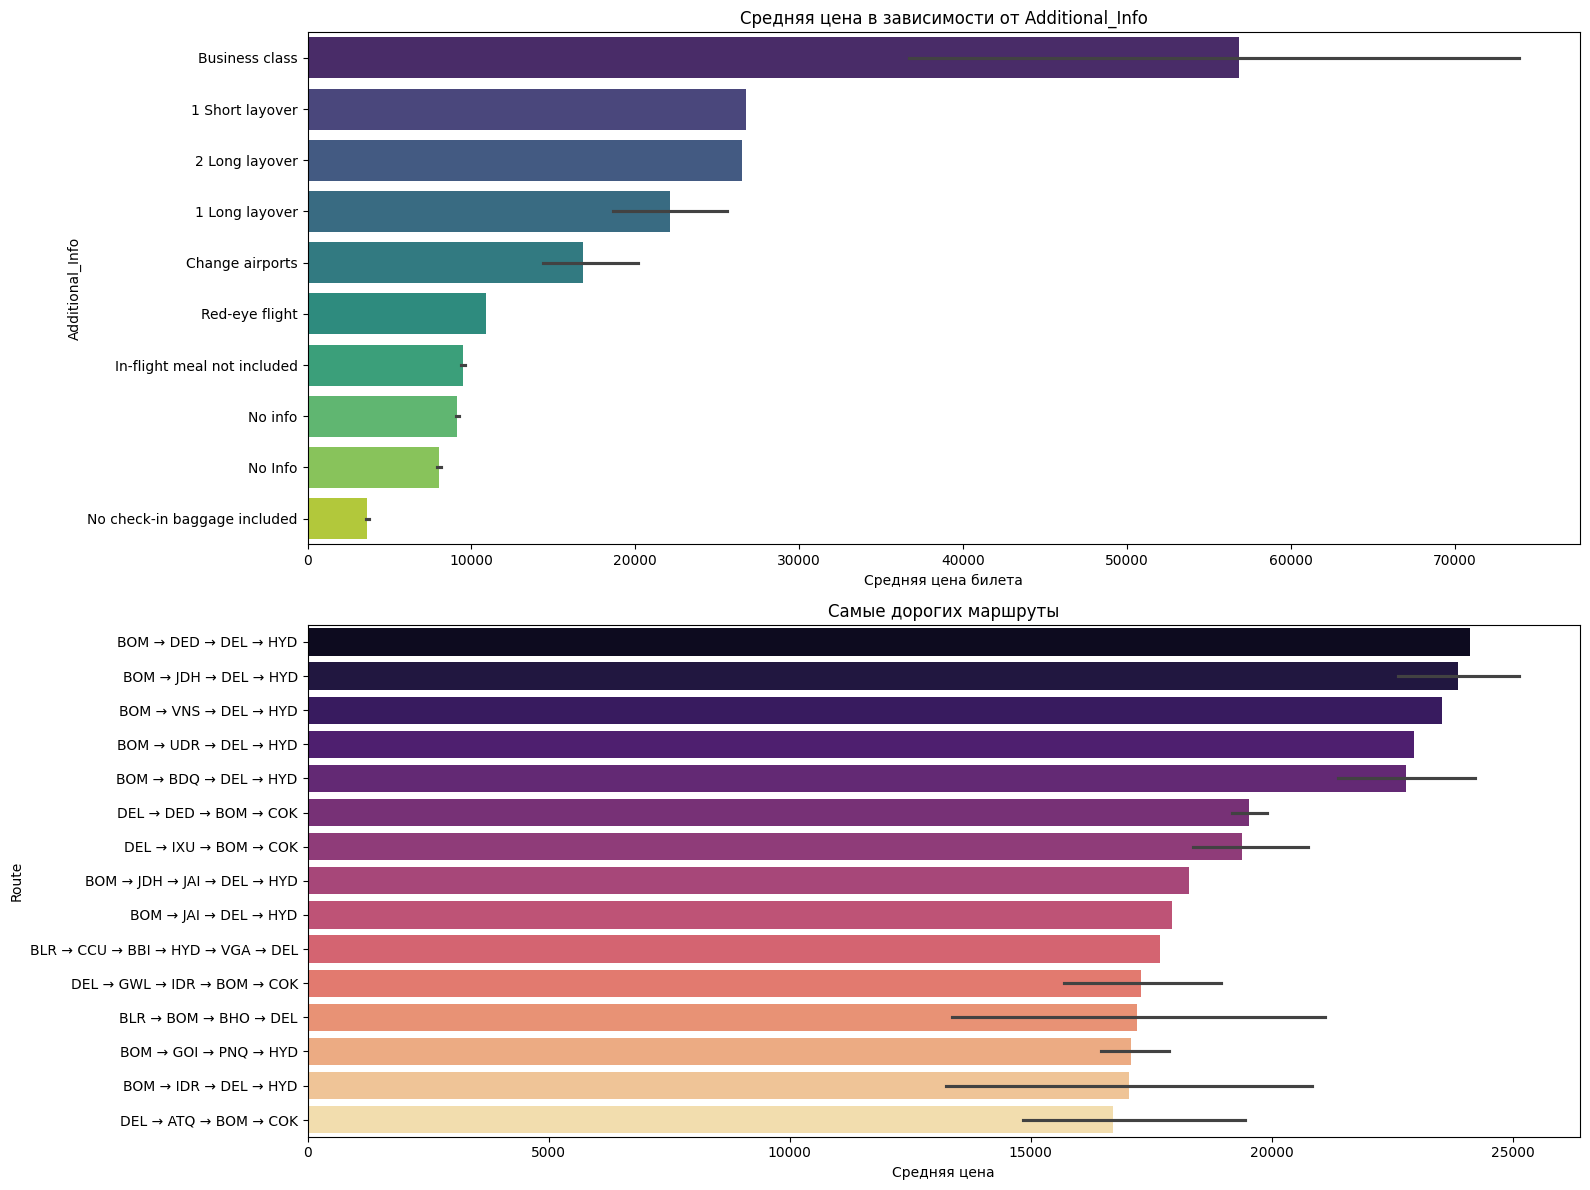

Статистика по Business class:
              Price
count      4.000000
mean   56811.250000
std    21381.667044
min    28097.000000
25%    49931.000000
50%    59818.000000
75%    66698.250000
max    79512.000000


In [15]:
df_analysis = pd.read_excel('Data_Train.xlsx').dropna()

plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
order_info = df_analysis.groupby('Additional_Info')['Price'].mean().sort_values(ascending=False).index
sns.barplot(x='Price', y='Additional_Info', data=df_analysis, order=order_info, palette='viridis')
plt.title('Средняя цена в зависимости от Additional_Info')
plt.xlabel('Средняя цена билета')

plt.subplot(2, 1, 2)
top_routes = df_analysis.groupby('Route')['Price'].mean().sort_values(ascending=False).head(15).index
sns.barplot(x='Price', y='Route', data=df_analysis[df_analysis['Route'].isin(top_routes)], order=top_routes, palette='magma')
plt.title('Самые дорогих маршруты')
plt.xlabel('Средняя цена')

plt.tight_layout()
plt.show()

print("Статистика по Business class:")
print(df_analysis[df_analysis['Additional_Info'].str.contains('Business')][['Additional_Info', 'Price']].describe())

Действительно, удаление этих признаков было ошибочных. Нужно вернуть их. Также подбор гиперпараметров для предотвращения переобучения, ну и на всякий случай сделаем логарифмирование таргета.

In [16]:
X_reg_final = df_reg_base.drop('Price', axis=1)
y_reg_final_log = np.log1p(df_reg_base['Price'])

X_train_r_fin, X_test_r_fin, y_train_r_fin_log, y_test_r_fin_log = train_test_split(
    X_reg_final, y_reg_final_log, test_size=0.2, random_state=42
)
param_grid_final = {
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5, 10]
}

grid_final = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_final,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid_final.fit(X_train_r_fin, y_train_r_fin_log)

best_tree_final = grid_final.best_estimator_

y_pred_log_fin = best_tree_final.predict(X_test_r_fin)

y_pred_fin = np.expm1(y_pred_log_fin)
y_test_fin = np.expm1(y_test_r_fin_log)

print("Регрессия")
print(f"MAE: {mean_absolute_error(y_test_fin, y_pred_fin):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_fin, y_pred_fin)):.2f}")
print(f"R2 Score: {r2_score(y_test_fin, y_pred_fin):.4f}")

Регрессия
MAE: 896.05
RMSE: 1765.40
R2 Score: 0.8555


Отличный результат. Он на порядок выше всех тех, что были ранее. Действительно, удаление этих признаков было ошибочным

## Имплементация алгоритма

Реализация дерева решений будет основана на рекурсивной архитектуре с использованием класса Node и жадного алгоритма обучения. Для классификации в качестве критерия разбиения применяется неопределенность Джини (Gini Impurity), а для регрессии — дисперсия. Процесс поиска оптимального разбиения перебирает возможные пороговые значения для каждого признака, разделяя выборку на две части и выбирая порог, максимизирующий прирост информации. Рекурсивное построение дерева останавливается при достижении заданной максимальной глубины, если в узле остаётся недостаточно объектов или если лист становится чистым.

In [18]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

class MyDecisionTree:
    def __init__(self, max_depth=None, min_samples_leaf=1, task_type='classification'):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.task_type = task_type
        self.root = None

    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)
        self.root = self._grow_tree(self.X, self.y)
        return self

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (self.max_depth is not None and depth >= self.max_depth) or \
           (n_labels == 1) or \
           (n_samples < self.min_samples_leaf * 2):
            return Node(value=self._calculate_leaf_value(y))

        best_feat, best_thresh = self._best_split(X, y, n_features)

        if best_feat is None:
            return Node(value=self._calculate_leaf_value(y))

        left_idxs = X[:, best_feat] <= best_thresh
        right_idxs = X[:, best_feat] > best_thresh

        if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0:
             return Node(value=self._calculate_leaf_value(y))

        left = self._grow_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs], y[right_idxs], depth + 1)

        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, n_features):
        best_gain = -1
        split_idx, split_thresh = None, None

        feat_idxs = np.arange(n_features)

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            if len(thresholds) > 100:
                thresholds = np.percentile(X_column, np.linspace(0, 100, 50))

            for tr in thresholds:
                gain = self._information_gain(y, X_column, tr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = tr

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, threshold):
        parent_loss = self._impurity(y)
        left_idxs = X_column <= threshold
        right_idxs = X_column > threshold

        if np.sum(left_idxs) == 0 or np.sum(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(y[left_idxs]), len(y[right_idxs])
        e_l, e_r = self._impurity(y[left_idxs]), self._impurity(y[right_idxs])

        child_loss = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_loss - child_loss

    def _impurity(self, y):
        if self.task_type == 'classification':
            _, counts = np.unique(y, return_counts=True)
            probabilities = counts / len(y)
            return 1 - np.sum(probabilities ** 2)
        else:
            if len(y) == 0: return 0
            return np.var(y)

    def _calculate_leaf_value(self, y):
        if self.task_type == 'classification':
            return Counter(y).most_common(1)[0][0]
        else:
            return np.mean(y)

    def predict(self, X):
        X = np.array(X)
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def predict_proba(self, X):
         preds = self.predict(X)
         return preds

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


class MyDecisionTreeClf(MyDecisionTree):
    def __init__(self, max_depth=None, min_samples_leaf=1):
        super().__init__(max_depth, min_samples_leaf, task_type='classification')

class MyDecisionTreeReg(MyDecisionTree):
    def __init__(self, max_depth=None, min_samples_leaf=1):
        super().__init__(max_depth, min_samples_leaf, task_type='regression')


In [17]:

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42
)

X_train_r_fin, X_test_r_fin, y_train_r_fin_log, y_test_r_fin_log = train_test_split(
    X_reg_final, y_reg_final_log, test_size=0.2, random_state=42
)

my_tree_clf = MyDecisionTreeClf(max_depth=10, min_samples_leaf=10)
my_tree_clf.fit(X_train_c, y_train_c)
y_pred_c_my = my_tree_clf.predict(X_test_c)
y_prob_c_my = my_tree_clf.predict_proba(X_test_c)

my_tree_reg = MyDecisionTreeReg(max_depth=20, min_samples_leaf=1)
my_tree_reg.fit(X_train_r_fin, y_train_r_fin_log)
y_pred_r_log_my = my_tree_reg.predict(X_test_r_fin)

y_pred_r_my = np.expm1(y_pred_r_log_my)
y_test_r_my = np.expm1(y_test_r_fin_log)

print("\n")
print("Классификация ")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c_my):.4f} (Sklearn: 0.9432)")
print(f"F1: {f1_score(y_test_c, y_pred_c_my, average='macro'):.4f} (Sklearn: 0.8926)")
print(f"ROC AUC:  {roc_auc_score(y_test_c, y_prob_c_my):.4f} (Sklearn: 0.9504)")

print("\nРегрессия")
print(f"MAE:      {mean_absolute_error(y_test_r_my, y_pred_r_my):.2f} (Sklearn: 896.05)")
print(f"RMSE:     {np.sqrt(mean_squared_error(y_test_r_my, y_pred_r_my)):.2f} (Sklearn: 1765.40)")
print(f"R2 Score: {r2_score(y_test_r_my, y_pred_r_my):.4f} (Sklearn: 0.8555)")



Классификация 
Accuracy: 0.9339 (Sklearn: 0.9432)
F1: 0.8784 (Sklearn: 0.8926)
ROC AUC:  0.8803 (Sklearn: 0.9504)

Регрессия
MAE:      829.06 (Sklearn: 896.05)
RMSE:     1774.95 (Sklearn: 1765.40)
R2 Score: 0.8539 (Sklearn: 0.8555)


Как видим, результаты метрик практически идентичны

## Вывод

В ходе данной лабораторной работы была успешно реализована рекурсивная модель Решающего дерева с нуля, которая продемонстрировала выдающееся соответствие результатам оптимизированной библиотеки sklearn. В задаче регрессии самописная модель достигла R2 Score 0.8539, что практически полностью совпадает с эталонным значением sklearn (0.8555), подтверждая корректность имплементации жадного алгоритма поиска лучшего сплита по минимизации MSE. Аналогично, в задаче классификации метрики Accuracy и F1-score оказались очень близки, что свидетельствует о правильной реализации критерия неопределенности Джини. Расхождение в метрике ROC AUC (0.88 против 0.95) является ожидаемым и объясняется упрощенной реализацией predict_proba в самописной модели, которая не вычисляет долю классов в листе.
Главным результатом исследования стало достижение нового рекорда качества в задаче регрессии (R2 > 0.85), что превосходит все ранее изученные алгоритмы. Ключом к успеху послужило осознание критической важности признаков Route и Additional_Info, которые были ошибочно удалены в предыдущих экспериментах, а также применение логарифмирования целевой переменной и подбор гиперпараметров (max_depth, min_samples_leaf) для борьбы с переобучением, которое является основной слабостью одиночных деревьев.